## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
import torchvision
import torchvision.transforms.functional as TF
import random
import glob
from torchmetrics import JaccardIndex
from torchmetrics.classification import Dice
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from torch.utils.data import Dataset, DataLoader

In [2]:
import sys
sys.path.append('../src/')
import preprocess
#import json2mask
import constant
from model import Unet

## PARAMETERS

In [3]:
VALID_SIZE = 0.3
TEST_SIZE  = 0.1
BATCH_SIZE = 4
EPOCHS = 3
CUDA = False
INPUT_SHAPE = (224, 224)
N_CLASSES = 2

## DIRECTORIES

In [4]:
SRC_DIR=os.getcwd()
ROOT_DIR=os.path.join(SRC_DIR,'..')
IMAGE_DIR=os.path.join(ROOT_DIR,'images')
MASK_DIR=os.path.join(ROOT_DIR,"masks")

In [5]:
ROOT_DIR='C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\'

In [6]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [7]:
image_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out')
mask_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks')
line_mask_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks')
mask_on_image_path=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images')

In [8]:
for i in range(len(image_paths)):
    image_paths[i]=ROOT_DIR+"img_out\\"+image_paths[i]

In [9]:
for i in range(len(line_mask_paths)):
    line_mask_paths[i]=ROOT_DIR+"line_masks\\"+line_mask_paths[i]

In [10]:
for i in range(len(mask_on_image_path)):
    mask_on_image_path[i]=ROOT_DIR+"masked_images\\"+mask_on_image_path[i]

In [11]:
image_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Sta

In [12]:
mask_paths

['cfc_000234_75576fe22f704a23816456740bde3556.png',
 'cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'cfc_000249_38679c112bca4107ad224a6e7fc10c2e.png',
 'cfc_000250_8e8d9b03802545a0bcac9b7d2b9578f1.png',
 'cfc_000251_d99c886d896745b7817ed667618a954e.png',
 'cfc_000252_bc4465e2f56b43d092575c4c6833b648.png',
 'cfc_000253_a7471156614d473db7fe9e5bee2ee247.png',
 'cfc_000254_388a51e56525449796c6c07728494a51.png',
 'cfc_000255_f3b724c3232d41588e2eaa5074740d2e.png',
 'cfc_000256_0c84da99243c439fa8e4117c1a10e530.png',
 'cfc_000257_71569acad2364cd5b5ca50878673b381.png',
 'cfc_000258_81fa1134d54949209bf05a8624328ce2.png',
 'cfc_000259_06d409725bef4251af86afad57a12ee4.png',
 'cfc_000260

In [13]:
line_mask_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\

In [14]:
mask_on_image_path

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',


## Json2Mask

In [15]:
for i in range(len(image_paths)):
    mask_paths[i]=ROOT_DIR+"masks\\"+mask_paths[i]

In [16]:
mask=plt.imread(mask_paths[0])

In [17]:
mask_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\mask

In [18]:
mask=plt.imread(mask_paths[0],0)
mask

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]], dtype=float32)

In [19]:
def visualize_example_fs_mask_pair(image_paths,mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(mask_paths[random_idx],0)
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    

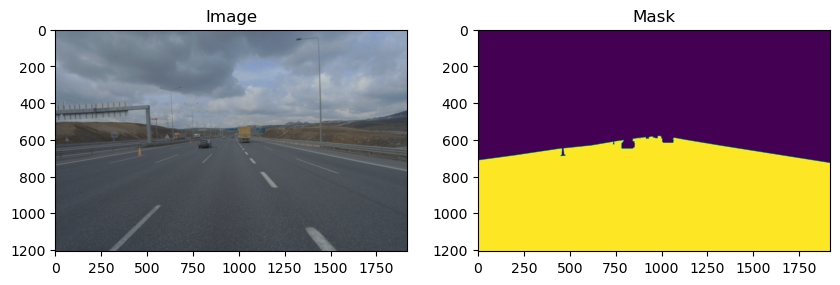

In [20]:
visualize_example_fs_mask_pair(image_paths,mask_paths)

In [21]:
def visualize_example_line_mask_pair(image_paths,line_mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(line_mask_paths[random_idx])
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    

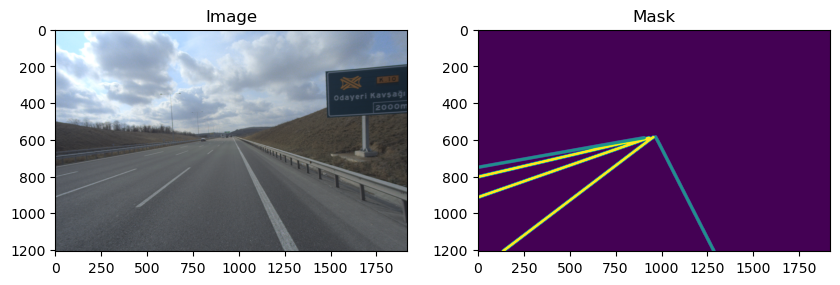

In [22]:
visualize_example_line_mask_pair(image_paths,line_mask_paths)

In [23]:
def visualize_example_mask_on_image_pair(image_paths,mask_paths):
    random_idx=random.randint(0,10)
    image=plt.imread(image_paths[random_idx])
    mask_on_image=plt.imread(mask_paths[random_idx])
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask_on_image)
    axs[1].set_title('Mask On Image')
    

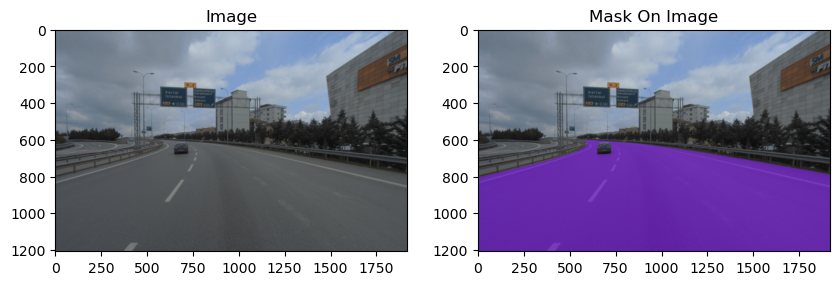

In [24]:
visualize_example_mask_on_image_pair(image_paths,mask_on_image_path)

In [25]:
image=plt.imread(image_paths[4])
mask=plt.imread(mask_paths[4])

In [26]:
print(f"Shape of the mask: {mask.shape}")
print(f"Shape of the images: {image.shape}")

Shape of the mask: (1208, 1920)
Shape of the images: (1208, 1920, 3)


In [27]:
for i,unique_val in enumerate(np.unique(mask)):
    print(i,unique_val)

0 0.0
1 0.003921569


In [28]:
mask

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.00392157,
        0.00392157]], dtype=float32)

# Preprocessing 

### torchlike_data() method

In [29]:
image=plt.imread(image_paths[0])

In [30]:
image_before_torchlike=image
print(f"Image shapes before torchlike_data() method {image_before_torchlike.shape}")

Image shapes before torchlike_data() method (1208, 1920, 3)


In [31]:
torch_like_data_example=preprocess.torchlike_data(image)

In [32]:
print(f"Image shapes before torchlike_data() method {torch_like_data_example.shape}")

Image shapes before torchlike_data() method (3, 1208, 1920)


We can see that at first our image has HeightxWidthxShape data format. Pytorch wants our images as ChannelxHeightxWidth format.

### onehot_encoder() method

One hot encoding is a method that provides us to convert categorical data into vectors. Fro now we have 2 categorical value wihich is pixel belong to freespace or not.

Returns a matrix containing as many channels as the number of unique values ​​in the input Matrix, where each channel represents a unique class.

In [33]:
example_mask=plt.imread(mask_paths[3])
one_hot_encoded=preprocess.one_hot_encoder(example_mask,n_class=2)

In [34]:
print(f"The dimensions of one hot encoded mask is {one_hot_encoded.shape}")

The dimensions of one hot encoded mask is (1208, 1920, 2)


In [35]:
image_paths[0]

'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000234_75576fe22f704a23816456740bde3556.png'

## tensorize_image method

In [36]:
list_image=[]
list_image.append(image_paths[0])

In [37]:
tensorized_images=preprocess.tensorize_image(list_image,(constant.HEIGHT,constant.WIDTH))

In [38]:
tensorized_images[0].shape

torch.Size([3, 224, 224])

In [39]:
tensorized_images[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

## tensorize_mask.() method

In [45]:
mask_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\mask

In [39]:
tensorized_masks=preprocess.tensorize_mask(mask_paths,(constant.HEIGHT,constant.WIDTH),n_class=2)

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000234_75576fe22f704a23816456740bde3556.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000235_a1468fa636f9496aabbec371327890c3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000236_03a390ba28534f28a60a2d626f674103.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000244_bf75244a4b09401580da886b35c340d6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000246_c18d4001d69044e295e65591cf0cb574.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000329_50df6dc5b43545a6a70151852a757e8c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000330_80b774aadc9d4984a477524a76ad1d3a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000331_fa27fa0b384c4c55a30edc321a3094c3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000332_b0c4f5783269479f867e9ad58fe873c5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000333_93536151c5af44a689027035dbbac825.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000334_447ab11f56ce4cb69757430414a7b316.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000335_acb163ed828a4819b005fa8b4d63e5f6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000336_117564d9396945cb92e9ae15e75ae9bf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000420_bad0850bbec842038e9169d43e35aae9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000421_d1e823b4924c423dae4df4e39d682a3a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000422_87800e7ef77442118c3cffa852e762f4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000423_c46bb5f0a57a4feb96f5a2c9912e2470.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000424_22216a1137244c68acaa590e4e0ad345.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000425_799f4a8bf8644f67b1b4a1bc12072821.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000426_f862ad0b98184c26ab9c3b6e7ca67c81.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000427_a5b59de5d9194b578d0b21344e1dbe8f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000504_9b28cf64f68e4a7c9ccd439efa4a1e09.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000505_59809d74dc78464d82198494b0ff2797.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000506_c8585c9520fb46c2b384a58b03bb9c20.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000507_7b273364cc3542349b9a6c6103e161c5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000508_2631a32f152947a69bab6ced02914552.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000509_c2db62e0fb64448f88f3fd05b705466a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000510_2c75f3304f434afaa3b9ac72a79fae35.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000511_c7c62e96180946bb9aa7fdc92ff793c6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000576_76e7209f618e4f9e9982cae69fc60b6b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000577_a9532f15fe1a4e5383913338689c9f4e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000578_679060b721104ca18c3833953bcf13ea.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000579_583db5207075474da34bd17aedc53001.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000580_664d302b695546d1a334463cb118fea7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000581_32e84791b251402ca55f0732d6de5d0f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000582_5f7686f1dd514619b4d919858d6f8b47.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000583_18709645105d4c61adf0636b0166ed11.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000662_2d49aea5f92949adaf1779fb83ea9d52.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000663_0b3050bce64140e79bfd79904c0b19f4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000664_0b0a515e755d4c80a7ff16ca162639a4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000665_c90ac8a5d7c94352b608922873da951c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000666_e24ae042515345b5a5fc4887878b3f6a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000667_10e59a2cc53448fb84cdf77b28679bab.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000668_a6cf4a0758924481908df4a575f99c23.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000669_cd133e0224f54f429081969d7aa51f43.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000756_f998823a9c7243949f1d27c87c8751ad.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000757_609f9163cb4d477692556dee49afd4be.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000758_4b0491bc3522414b9b55e4b51880e299.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000759_375944f37d8d44b7814b586fb8c44598.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000760_0136ffa784da43538bc5844e9320c659.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000761_775599cf7ac94755a3115100730cfa48.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000762_027bb9871b444bebb897935055fcecd6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000763_32688cc053f04ebfa702b16df2482874.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000845_f64bec28ff59402aa5a8e5f9de97da84.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000846_beef3a5d1c614cc085dfd784bb64861d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000847_1860f0bd04ad4c8cbd9c9b732ad0b477.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000848_e49e010ebc3943a68d909a6585bc63b6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000849_a66b5b47c009487b9a6c70ae25602040.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000850_710a6b4ba0084761b31ae737887bd949.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000851_e385d559e0114fb786910accb72e20b1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000852_07bb335141ae4217b7fbfab47d284172.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000922_91e49ee7986741d980530d87b21dbdc4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000923_26e8c99b4b4e4c98aa7e554b9e3a4229.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000924_30cb413b85154c269fc57399ca3e5eaf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000925_937f7735d5294ed483f1fc5d361e0e81.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000926_73b0e883fdf44c07b350eff3ac18aaef.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000927_f469be6b7ef745d4affc2fa21cb110fd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000928_276d7448b4024297ba3699ef13325339.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_000929_e419c6aa9fc84d828ebc10057c63e2f2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001010_1367b6ff0f84403cb2d35bdcfd2bdd80.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001011_089071e99f6a410d8d30f53780dba891.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001012_b1815b4194ee4e68824204166e83f869.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001013_5b3fbbef92534cc69dcff091c50cc157.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001014_cbf64263e3624dec856c37670a8f7946.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001015_0060312b1e954381932b5ec2010954c2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001016_6ffc448c6fc945aba00d791a830d515a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001017_8085d796f11a46239574bc62887bddcb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001101_ea104026d68142ba80b9566dfbcc3424.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001102_ec16e2e8341b4b08b88f54a93a66ec0a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001103_161d262019214590b4f39b0b24b980b7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001104_7ec4b823eeea4fa68578104626fe5023.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001105_2a9a6d1a863141a39db59b37b02063a2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001106_c349860dd0654dd0a7c17217ae89b1f2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001107_a0e262c29f4f4397988aa6f603901463.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001108_d3457e9768cb4383af8885322d6120d6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001191_570c72e12d424a15a88d25c8f4d95412.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001192_eba07d23cabd42e6a1099a43ce89a5b2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001193_1957500e73a14049bf7b5071f27d6f37.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001194_88886a0b39a54aa2a5b77e271566b83c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001195_9bf7fd37b2e24036898f061dcc02282a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001196_d0c20c3cd26748628859cf6ace40c204.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001197_aeae65142e5049f486d2c80da400a856.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001198_d6373439fe8742ccbb1b48500e1b42e5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001282_25a244ff18dd4999823cb4d9e86d293b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001283_5c9fff0b45e745f2b0cf01b93d5845dd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001284_38db942d116e414d8b0e7901af60817d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001285_8e9032e1c9404f7a84acbac119cf0998.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001286_6dcaf7986b9248a780556aa2bb866ba5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001287_fa3a95dbbff340a7b303cfe2efd356e9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001288_2cd528ae44d04e2eb356f971edc08206.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001289_a3bb3b818bb747428779626fb81acb3d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001360_734b587973ac439e903e0c5def0cc206.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001361_ce3e0ee4ed7e47f78fdd95df56941eaa.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001362_8e67b9b2f7a24c4ab3abc3f9fb570ebf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001363_24b2c7398a734bc6919071ef66ee610b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001364_bcc96f8d6a7d486aa7110d5f4619a470.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001365_59abdcfd7787499bae2b32e6032abc6a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001366_52b2d124043342dcaed60d9ef1f510a5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001367_4373b5084fca4401914ed75cae04d468.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001452_52015d22fa094bafa726980ca846a168.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001453_18b29e24b7fc43d58a84bb24ac2a2779.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001454_fc6cc95bd6864d648c430cc0d740d8d3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001455_a5562398b41e4fe29622e1e1b2515b4a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001456_6418a912105e47acbe351c1360c137f9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001457_19ed979bddb14fc1b64fcdafdeb87f59.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001458_0b3104bd827d4ca6888d1f0678cd884b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001459_f4a20dab7a2840aa855845a6c0b51b40.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001541_d286e73329e143e886a7c9fce07e21f0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001542_5e626d4661a4429b8386702ee19c58a4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001543_27a7e09939aa44d698bdcf0f4d9c75ed.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001544_14a2286a8aad4a3fbf1df4047b6420a7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001545_6a35829c53b34bedb77dd91114d82010.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001546_119e0ebac8c5455f82a14e8a395df714.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001547_969052f4749f44e49df4e49b0bd80683.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001548_6ed66751336445f591a67fc663d7d72e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001632_e2bd6a5c419e4bbead473aee435649d8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001633_8955abc32b7047498e007de19b3bcc61.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001634_6e91e06071124cac943bd80d16ad492a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001635_71906735815947c8a9be571d228de80f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001636_4ba1780121184a1f9eaa162bef4c78c0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001637_a53f4a38e8c14a078339402a0e22597f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001638_c5e67d5c1eb24e88be1eb08e3e1d4963.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001639_7f309cbb1dfb4932adb95922cb85256d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001704_dfff02e119cc4ec4b73986b147330dbc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001705_bb7cb8adea554288ace9f229dd75a4bf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001706_2366696f8f184d46b80937eae25eea48.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001707_f37af78ef5db4c15956f3c51e669ee50.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001708_3779621cc22a4a548bad672452cb1899.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001709_169a3b0c105d464e8bf44640a6a20c60.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001710_a57b365ebd874b63af88c8fc11b711de.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001711_d6bd00e4514a4aeaad0d2d6ff6b87f59.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001792_cf11d5dc2ef44b7c8a2dea7f8cd9786a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001793_ba6c942dca464ca190bc23d8061a25ea.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001794_fd1196007d37487cb9cb8a6411ff308d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001795_fb5c95b4317a4e84941cc7588a19e2c8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001796_9c033d429dc8442ab8e1867b3b6ade55.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001797_0985a90756d64243a9bbfdfac5dfcf4a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001798_35cf9555ef89457ba07ab1ad34baf8e4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001799_910be3f0f45a4f89aeae02406aaf0943.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001863_4546773d8e0e428db7b6b6c7a1f4e21e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001864_4657749748e14a01817389cee7cdd540.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001865_70ad2aa6c07b4620a13961d83b7d6810.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001866_6888616264d4449a8858028cf7e912eb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001867_d08cefc70ea14303aea25ea8b3678752.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001868_4f4af433b5a64e2c894a92aa6adda8ab.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001869_1f0a5ba17bcf447abd2728d395979d33.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001870_253e4dd0d6434a26995df880234d1b19.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001936_3d0e1de8a7ab4354bbb710e0d5bd0e02.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001937_d642e9fff1fe4927920e321fa5bedbc9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001938_0fe978f58a104c309336e227a8b4b50b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001939_2562426734634573aa8e57ea814ac0d1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001940_69418431a5894e10a18acbe48da8903c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001941_5d4e25c93ce34824b45f14628c29b281.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001942_a150409e33164e9bae7d3d026b0e061a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_001943_62520995ff1a44f8a423e06b72dbdb95.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002020_04180df5ae6f495cb9c10a3d892078de.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002021_1773eaa4be964c0c9069ab9da11499cd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002022_741992269c2347a381e45b40422650f3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002023_c46d287f0c834e62a22a23f24ec1130d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002024_4c78195324ae45c1b4146b2f1f91ad15.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002025_cf12b56309e842a9980989c9210e7117.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002026_caecfa985c954eeba9e285bd8c492825.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002027_ea1e68fc8e9440948273b593efa01543.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002093_4e53e51831ba4da7ba6871ab074eba8b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002094_2301b8a55577414ab3964c9b97dfafa5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002095_59d7f4daf92046b99dd8022ecd5ec22f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002096_ea08ee3b13da4c3fadd6d837648cab66.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002097_cb58a2772d144e2e8824b4cb73f5c3d2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002098_f855d3cf7d334add9b95624c614fea90.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002099_1d15470657cc4f7ca8d3a28c82dbc8e3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002100_a532b23951aa4fc78c48ff748a17fb9e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002165_4e1226716ad5489b8041242cc519ae21.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002166_59284797ba0a406885278de38f8be839.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002167_09c772bc872d4c708d8ecb4e3b4dd370.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002168_90f51a06331149fb911d8e4e9acfdd40.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002169_0c15b8e726984d4db1e440b0c07c7955.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002170_d32819a5749c4a0295e025af3091b440.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002171_d7e174a4f76c452397c4d5a840fc0d9f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002172_2cb9637f9afe4938a2d56234d9b2ec81.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002236_60e050e6114144e19307e9b62f53ee91.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002237_c4263efcfc22467099cc4e0a2c07cae8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002238_c2efddf2bec44e77a7fdc948a0dcf668.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002239_b3e2eaecde184b8f8e2bcb4437637b01.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002240_0afefc70e0a54be89854008f06085db4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002241_cd572e88b96b40a5a43b148e57900b87.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002242_6828b70bbb454d69ab4abc905d623ca4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002243_e88c71e8d9a14465ab2c9a56e34353cd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002329_6fb30ece60834cda8c8e2eb4963b291f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002330_580ed28d0ab04bee90439f8bcf4f1101.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002331_e600eb2a193e466ca418fee2fafd6297.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002332_0c80b1744ceb4b36934b26d8e33a818f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002333_2e170eb7f04c4478bb97cd949b4eb317.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002334_21a67e3ee8a341c78c1461719014e20c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002335_2f906c0ef8bc4ee6b646b0e07e4ca945.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002336_6359763719514727a8ec7060ce580c50.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002425_5b9aaa5ad77d4ff8a33ce78911504da7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002426_557a03faa65846b8b47cf7d7d704369d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002427_a1f1136da532405c88ef203216d882c3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002428_a163817642f7429191e96010320b215a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002429_b64384b44bc245ab8d34597f10e48cfa.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002430_aef491cc4a9b4d6ea2382f74faadc3e9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002431_cc1accf68e724d218b7f6ceb1c273913.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002432_0d83168f108c477a9076ab8ccc35f805.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002508_488fd8ac2902405ab9d0da12d2d2cac2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002509_d0beac3fd13b4fcdbfdd1a4c614f7070.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002510_117bc1b5c9b1449394875d18552d8001.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002511_2a8c07da3ff24a51a390e21e27b19566.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002512_8ef56fec188e434f896d86b036fba837.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002513_c59d42e1d70b46fc94de3aa76ebc7235.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002514_41edfd4a77154ec799847f5a569a09be.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002515_f1086445be394d85b25576efac33ca88.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002609_01fed5f9f31648b582c9dc4644afeb55.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002610_023384009ed34eceb3dbdf20e0c9de36.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002611_40f173b997a248468519bbad95c31d90.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002612_5c1da1bddedb4234875fae2a469fe829.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002613_a34aa025212f4a32b76a56018533d214.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002614_2e5256f207454e7ba27b6e3e65668f60.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002615_42f48e0965924b1db82eacf27811e8c8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002616_62f121d01905479389362db241dd5466.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002703_f89c5e3e9ae945b8a611daafd95a80ba.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002704_fde6231b974342a0af2fb6f15b7447e7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002705_216fd1c93852415fb2602a6c52be1e30.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002706_0d51498e6ed64557a1c6c1d2328fa7d2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002707_84b27ad3404d497fb3e3f2927da96a5b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002708_dde7d4cd69fc40ce8284b8bff7a778e7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002709_4c967064f43543c39d6a5a91203674d8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002710_08528590dd70419ab1b65ee86d7e8a73.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002775_300db27633cc4279894fce96e11538fa.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002776_ffd192b1818c4353a3fcac0b6119c0d3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002777_13f37676352c4324bb93128e89aaca38.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002778_5b30cd84ab844460abc08cd88d9096bf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002779_7b2f5ced7f024206b149d082f38bf9cc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002780_564c066f4dd84f988c9136eb5f0dece7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002781_a89b88de3eed4c4798288d99ceb0538c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002782_1ac73192c82645c98b3928a2b3c9e4af.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002849_b9ff8ceee23b42bfb1da483c34d52cc1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002850_a3cb288b575d48c4a5229e64983be791.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002851_8159f3fc92dd4b06bca32305223c676b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002852_752d5416035140149cfc658da05549ab.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002853_4a37ffaf8f234f7da861a5316fede23a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002854_3c81ff8523aa461d8c5ed42bfd5fb9c1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002855_1a4d7eba91f1437983ba45d593e1caa7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002856_8a4e7fb8d2a74818bcc1adbcbe228247.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002942_f0b91cd375df44baa1fc4dbedc4df8f6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002943_901a090a188f417eaa14e5792f8f436f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002944_e8302b4ca0f1461997a034bbf80b80ac.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002945_892d8d91a49c4b418be40c60dc377b16.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002946_6d5599aea656426c9f92e74f60016ce3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002947_4490bc97d41c424b891be9d5c75158eb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002948_164fcaf9278b4cecbd05954e54b1c074.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_002949_4eedc610f67541ca8e01d91eb352f047.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003034_e76c709de9534a77a60243233be489b7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003035_596d83d5f2964a6abbb3d98722f30f4e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003036_c319c25171bc4d89abbb5bf2292a0071.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003037_12afcba01713414e99884bd122095f27.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003038_a80768de53934336a9ef03208c010a8d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003039_da502cdb60af4d90b2edef4fb197afa9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003040_a4befcae569047e2aa8e2022dcc5ff36.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003041_52c033bc093e49ebade7837da3f4a7d6.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003135_8810fa1a2d2f41bab2b8a9d68f3fce36.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003136_6a8ad0b223b848c4bba1c070cf7d1872.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003137_9aef32d5da674093a81de0528c6f1c36.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003138_dbbb420c9aa54cfdaa46ac34baf98db4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003139_f8806b3a17e54fdca01d39a779676623.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003140_401e87614687494b9189de4c4ed7b197.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003141_31a20e8b3d5b4e7884798f04c59b574c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003142_f9668bd05eb4443d90de557a4f3c3930.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003210_2fc0be4981504b6ea29413946a511005.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003211_b6a8d90e27af4466b42022690ce9bd9d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003212_c252edc525fa4699a1f468a25446f1fd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003213_92fea424f5694f5497382d03bbe0d7d2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003214_fa4a96c2ad624dfba0a8c3d0ebba168f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003215_913e0a24093a4b65baa6b3c691ccf70f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003216_e9b957af910c408d91069690e6fca081.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003217_178a57a1fad84d2b872ee81730a46c00.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003283_21c206f786de495b99a0147e7933d1eb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003284_10289b366e4f4601a069a3289619c783.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003285_11c32520284343629f4dd90272a72185.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003286_e32076cc0b4d47ada4eae4cfa3a72ee9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003287_f8d115e94f7d458cbc3f25bbc317488e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003289_51f0cfea0ef54e1c928e095351c6caec.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003290_7aaf0d94b70b45a68bdbcb3ace072b1c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003291_c1e998b93d2c4574b4090b3a2c4dc3d3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003366_ad1e4ff296ae40779f3d07067eacedf5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003367_9102970e7bfb4675b89f212bb2486490.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003368_c73da87b890348c49d89f45297877149.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003369_f25a3b3d3ed44be793fac702aa4c5e18.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003370_d69e2eecf93b4b2ca8eace2cf0bed580.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003371_1f9ea43794f54a3a8f31e5a56eef6843.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003372_e6704b80e1454c6ba4f55d58e2e60020.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003373_0266d057d38a4acab713f4d8fa66b8fe.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003443_0ae142eb553f4402a9d80016907894b9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003444_76911f0abfcf465c8a5621529d5c08ec.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003445_a88f4164caea41d28c043bb686731402.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003446_14943b6c4ae442668e42e3c91df049de.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003447_41862c2cd0b541b8bf05762e624eca05.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003448_6caa099ab9ec457aaca114ad702d724f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003449_03f22fb993f042a194f70e736bd7e426.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003450_ef8831d91e84498ea4d632bbfe38c9ea.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003514_a644514aa2074db3a4a0ffadd633963e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003515_cfcab1cd24f243b4b285c3a9fbaedb4c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003516_18e49be36f9140dbaf1926c5bfb1048e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003517_3d340e687d0542d28b4033e3177cc3e8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003519_dccc7e61846e408784f5066e986afcda.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003520_4ca687a7d3874d3a9ba65ac4bf2f5d46.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003521_4dcbaa1c809748cbb9d54b80ac831730.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003522_94fea6a46de141ba8a76c1255a00a20b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003587_f9245b12d51243d5ab22b49f4b2b2cfb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003588_69c2a9a29c114146bb36c0642d90926b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003589_d02ca1e2583944aabfe20c7db4962df4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003590_d3eee28a1d7c4871bd6227c03734c028.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003591_06ce8dd3a2bd498eb526571275441dd5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003592_d0f9f9e3496d4da19ad9b1073c10cb71.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003593_301a1652569e490b868ed5edbc065ceb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003594_6ce17912a6684856a5cc88770799d192.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003663_160e0d51644c4d7b9199edfb3161972b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003664_c1da0a00ba314448ae927ec18d6681a1.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003665_fe4ef97b30a949328a481cd23c5847e2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003666_f6032bc6bc8142889684da50df9f7dfa.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003667_d6ce3217e64943839307746f906683d0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003668_f890897df4f2445c9c58cf32b09aab68.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003669_6d27c3b00d9140c2925ca1409ed8523a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003670_4ac6d551f5d3416a8954bf35d11bded7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003757_f1a4d859d3b745cb8489ef417812a296.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003758_7723120749ac4661a9d14bf3cea40c2d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003759_1de490a8cbc5439687b2dc416f77164b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003760_11f480375e6a4a80b0daeb8660170f64.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003761_a962898e442b428992cfd8ce8295e5dc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003762_5eac6a5053a74b1d9e86c369406d2b64.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003763_3df3f086c2df4a99a7b138c8ffda3977.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003764_92c62f20f6e2400b806ce84887b320b8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003849_e8fd53b22fce439e8b665e744eaee51f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003850_43ae5421fb1042c4a2db88f07c1308fd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003851_6b7a9989bb7a402499da932e31273668.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003852_9403922a89e54433b539b3a051246236.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003853_f3bc705f31724fe3bab8d4f7cc230669.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003854_d6bdfad083e6492cb6fbfbeeb4157708.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003855_b4a0ba3feae34ca1b2ed66b1047ec42c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003856_26f9d7e08a0e49939339bc10edb3c154.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003944_a0025de67b444d90a987e8bcbe8e3105.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003945_6b503199c80941a0847d58978d612d9b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003946_bc83ec098331485fa9e1cf45a0ee1b89.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003947_4aacc1e0fa6b47159e7bfe2804f16d7c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003948_ab76bd488f47468e8b368c5690ac9b82.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003949_e947fbc880e14f2dbd7f6772dedc01f2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003950_4c2d2e60a17240ddb9259d054d8e44f9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_003951_0d36ce379fef4112b7e547d2b50f29b9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004037_0820b8d3245c439eb0dd51c41dbc9a08.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004038_fdf41a2c66a147dc9753e3abf6824a62.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004039_7becbfb4b14a4d70823737e2becf84df.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004040_d4fb2cb6a5404fe4b9e07a54ea518243.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004041_9222cbee89af4e44ba689c40b150b678.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004042_6118fa0fcc28487aa0fad6ae19c79039.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004043_f048d7bb618941e1988461f0a02f4ccb.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004044_2801a650437841d48704a2a3e0f1e374.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004111_2f787e727f754effbb1e15f2006f369b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004112_ecc23182e91c4dafb851b5f871caf81c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004113_d126300584224ffcbb74bf5c52275fc3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004114_202824d0b1784bf7b59d604f618fa9fd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004115_3a455a7e8d9b47e0b1e0dacadb8e0687.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004116_884e4ddb1651423496b8f694ce274c77.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004117_6d10df64b27f4d09a04beeecb6c955e3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004118_5772f9e989a14e5b8db486e15c174702.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004203_00435844818e498a94503cb9393988bf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004204_740e55a16c2149dca5246bfaeed944bc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004205_a4823b17830648de8323f00af31a8d73.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004206_bdb67a6d46b54b0c9c270d05a3ad332a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004207_5b3eadce1f754d6fa9db84ee5b630778.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004208_c81a9959a94742d6a68d0072e29a9390.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004209_8c2ae08495c04560ba687c5a15272188.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004210_a3cb1e180962482699a8a4b50adbe192.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004296_023ab91f37964c3d8ebe2de77005fa2b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004297_d45b75389408456aa86c5a8fd2cb2af9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004298_33667f16b6724f4bbfdcf85c13f0f018.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004299_77ee3c9ce22f40b4afa6925514102b7e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004300_ef9f0281106c4522a3245d5284cfc538.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004301_7e79355c08a340279f8a5cf7527eeff3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004302_e455ed3f5930403eb4dcaf379c2a5825.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004303_fbae5892a2154c31a6de6c67d880c1ce.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004391_c0c46849fd3544bab6c660eb42aad54b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004392_964c877004434cbaa0ac827fe4266b95.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004393_447139fc13794b80b780b22fa671fe6f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004394_e831086362554d5090d7e9334e5edbb9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004395_ffca4fa7669543d48bbc74733ab285e9.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004396_183c7213913241d5b587061a6b3a2d1b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004397_f794285f5b8b4b30a63a1ab36da1dae3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004398_11b66467322b4c86b802d5e893c0f3d2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004489_d10f78f9ec7c47c78898a2b196ab6e28.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004490_f784de4e5b81477c9e782ffeaf336f74.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004491_18202a5f2a9c4d6199af5b1b0895ddc4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004492_3555047369ea4aeabaa84605686408b5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004493_2c4da079777b47eeaa5faaafdb1c5c8c.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004494_4fcedf7bd06446039152390a003e47ab.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004495_ad7ce350e06345d3a8c6db7c5348c8bc.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004496_b5c20a800b6e4198b14cee46e5350598.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004563_271ce99f4f3349df87ae1745d3a6b4f5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004564_e683b46d01564034bfe49c18e593ce0b.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004565_e089a7c4833f4e6380e3bd694f97c40e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004566_f95ce41f22c8446d892319b7d06260e2.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004567_83c392ebac2f4909a313d2ab5568fce8.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004568_2e1f4c8b87324201a0a5ff29bba03d78.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004569_e1ea445c9cff4afca227fe6b161c9fff.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004570_44722f2689534d258a8deeadff198631.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004634_c0c616e545ff403a9a826ba743d48ad4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004635_9a20055edbf848069d574a0b1e24478d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004636_12c4033e372647cc9723495326cea9bf.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004637_6f1029fa878c46529de11da56bbc6ef5.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004638_c9a49e8dc01b40b68d4312350808a3d3.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004639_47d87b5a99984e46a724e1e6b66c800d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004640_a0335b964607460b8c22e9eabe620014.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004641_cb62860f6c6d4f019c5ace1c9f1b2b8f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004720_8f1966806a274eed88fe9b8f1e891a51.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004721_045fe9732bec4423b13387c4aa1f13ca.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004722_96632412d5e841b49d7fcac554a6fc89.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004723_cd7052468f584bd2a7953410b842b108.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004724_24e154bc5f154a38b2d285f61a10051d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004725_3ffc5c8bd97c4bf79351a7d77328d87f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004726_a3977d3bcbf1474ca2ed41366c0fdb97.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004727_996df778a3ca41fc824731b5729eb29d.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004794_736dec7e31a844729c03991a481dd213.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004795_40ff90c47342470baac7f091122c521a.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004796_5833e4fa049546928d71c3c281cb1d26.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004797_dea56c323322417292211ba6a7aa62d7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004798_9fd6e202a11b455ebc8677529c9219ac.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004799_db7cc8a433474b23bfd405fdc1795b28.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004800_01b25d532b694471b4fae38c849606e4.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004801_2f207d3e54764c82bd97c018bf7fa580.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004887_21dd27090cb640378895d20b9cbb3d3e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004888_122a3b603941408c8359c6de8860815f.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004889_c39c9cb053854627b62e7c27fadb4a5e.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004890_f5ed479efb9b4f5c9da69a3a97f39d67.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004891_59867f902ad140bd8cd03eff407af354.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004892_f536db9f5930462fb6e06988a655a5ac.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004893_323c09b99e6c4a9197fcafb353735132.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004894_0e9f1c86703d4205a0c21b3587eefa83.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004980_76376b2c38034d4091265d1299522474.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004981_ab2d923e4a684c7e838b1551887c2f57.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004982_76f4e0b57fec44b9b9ad452c16a4a0b7.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004983_ecae496fa3e94c83876ed761fa1fa319.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004984_5e23c82985234b6dabbe100c373c0ef0.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004985_47136a77007441c1ba0436902c2fdcfd.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004986_340ce19fa306487597c2742499172464.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\masks\cfc_004987_73af6fe1257f40cea41bdff099142731.png
mask path:C:\Users\Beytullah\Desktop\Ford Otosan Staj Verileri\m

In [40]:
tensorized_masks.shape

torch.Size([4660, 2, 224, 224])

In [41]:
tensorized_masks[3]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

## Model Training

In [40]:
# PREPARE IMAGE AND MASK LISTS
image_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out", '*'))
image_path_list.sort()

mask_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks", '*'))
mask_path_list.sort()


In [41]:
# DATA CHECK
preprocess.image_mask_check(image_path_list, mask_path_list)

True

## Train, Valid and Test Data Split

In [42]:
indices = np.random.permutation(len(image_path_list))

# DEFINE TEST AND VALID INDICES
test_ind  = int(len(indices) * TEST_SIZE)
valid_ind = int(test_ind + len(indices) * VALID_SIZE)

# SLICE TEST DATASET FROM THE WHOLE DATASET
test_input_path_list = image_path_list[:test_ind]
test_label_path_list = mask_path_list[:test_ind]

# SLICE VALID DATASET FROM THE WHOLE DATASET
valid_input_path_list = image_path_list[test_ind:valid_ind]
valid_label_path_list = mask_path_list[test_ind:valid_ind]

# SLICE TRAIN DATASET FROM THE WHOLE DATASET
train_input_path_list = image_path_list[valid_ind:]
train_label_path_list = mask_path_list[valid_ind:]

# DEFINE STEPS PER EPOCH
steps_per_epoch = len(train_input_path_list)//BATCH_SIZE
print(len(train_input_path_list))

2796


In [43]:
print(len(train_input_path_list)//BATCH_SIZE)

699


## Train Freespace Unet Segmentation Model

In [44]:
model=Unet(in_channels=3,out_channels=2)

In [45]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [46]:
len(valid_input_path_list)

1398

In [47]:
valid_input_path_list

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000715_029f19136f5e4172a1ba400be4e63b37.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000716_bbe2b281a2f1485cbca47a9b84cf7f40.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000717_90be3c1f8bdc460296f703bc8d690760.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000718_b370c053eae44ce8a8b8c7a5b9393e3c.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000719_82a26e4d545d4567b07447c1019afc30.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000720_b9201bba9e8b46ad877a6be56916cace.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000721_3b08becf561042698f44e128ee121a31.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000722_ce0acc19b5a749a5a9b6f5de7e9f5b0d.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Sta

In [ ]:
from tqdm import tqdm

if CUDA:
    model = model.cuda()

# TRAINING THE NEURAL NETWORK
for epoch in range(EPOCHS):
    running_loss = 0
    for ind in tqdm(range(steps_per_epoch), desc=f"Epoch {epoch+1}/{EPOCHS}"):
        batch_input_path_list = train_input_path_list[BATCH_SIZE*ind:BATCH_SIZE*(ind+1)]
        batch_label_path_list = train_label_path_list[BATCH_SIZE*ind:BATCH_SIZE*(ind+1)]
        batch_input = preprocess.tensorize_image(batch_input_path_list, INPUT_SHAPE,CUDA)
        batch_label = preprocess.tensorize_mask(batch_label_path_list, INPUT_SHAPE, N_CLASSES, CUDA)
        optimizer.zero_grad()

        outputs = model.forward(batch_input)
       
        loss = criterion(outputs, batch_label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
     
        if ind == steps_per_epoch-1:
            print('training loss on epoch {}: {}'.format(epoch, running_loss))
            
            val_loss = 0
            for (valid_input_path, valid_label_path) in zip(valid_input_path_list, valid_label_path_list):
                list_image=[]
                list_mask=[]
                list_image.append(valid_input_path)
                list_mask.append(valid_label_path)
                batch_input = preprocess.tensorize_image(valid_input_path, INPUT_SHAPE, CUDA)
                batch_label = preprocess.tensorize_mask(valid_label_path, INPUT_SHAPE, N_CLASSES, CUDA)
                outputs = model.forward(batch_input)
                loss = criterion(outputs, batch_label)
                val_loss += loss
                break

            print('validation loss on epoch {}: {}'.format(epoch, val_loss))
            

Epoch 1/3:  40%|███████████████████████████▌                                         | 279/699 [15:26<26:14,  3.75s/it]

## Save Model

In [ ]:
torch.save(model,"segmentation_model_unet.pth")

# Inference from Trained Model

In [ ]:
tensorized_test_images=preprocess.tensorize_image(test_input_path_list,INPUT_SHAPE)

In [ ]:
test_outputs=model(tensorized_test_images)

In [ ]:
pred_test=test_outputs[0]
pred_test=torch.sigmoid(pred_test)
print(pred_test.shape)
pred_test=pred_test[0].detach().numpy()
pred_test=pred_test>0.50
print(pred_test.shape)

In [ ]:
pred_test

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(10,10))
axs[0].imshow(plt.imread(test_input_path_list[0]))
axs[0].set_title('Original Image')
axs[1].imshow(plt.imread(test_label_path_list[0]))
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_test)
axs[2].set_title('Prediction')

## Evaluation

### IOU Score With Jaccard Index

In [ ]:
target=preprocess.tensorize_mask(test_label_path_list,INPUT_SHAPE,2)
pred_test=test_outputs[0]
pred_test=torch.sigmoid(pred_test)
jaccard_index=JaccardIndex(task='binary',num_classes=2)
jaccard_index(pred_test,target[0])
    
    